In [1]:
import pandas as pd
import re
import numpy as np
import os
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)

In [2]:
df = pd.read_csv('Data/DF_Combined_2025_1h_Featured.csv')

# Drop unwanted columns
drop_cols = [
    # "BIN_Future_RET_72H", "BIN_Future_RET_120H",
    # "BIN_Future_RET_168H", "BIN_Future_RET_336H", "BIN_Future_RET_720H"
]
df = df[[col for col in df.columns if col not in drop_cols]]

# Convert 'date' to datetime (important for indexing)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Set MultiIndex: (coin, date)
df = df.set_index(['coin', 'date']).sort_index()

df.head()

RET     close      high       low      open  \
coin     date                                                                   
AAVEUSDT 2025-01-30 23:00:00 -0.00574 315.36000 319.48000 315.13000 317.18000   
         2025-01-31 00:00:00  0.00999 318.51000 318.63000 313.26000 315.36000   
         2025-01-31 01:00:00  0.00546 320.25000 320.41000 316.68000 318.50000   
         2025-01-31 02:00:00 -0.00987 317.09000 320.75000 315.63000 320.25000   
         2025-01-31 03:00:00 -0.00369 315.92000 317.60000 314.00000 317.07000   

                                  volume  Mom_S10_L168  Mom_S10_L336  \
coin     date                                                          
AAVEUSDT 2025-01-30 23:00:00 15502.90000       0.00683      -0.02506   
         2025-01-31 00:00:00 25200.60000       0.00734      -0.02484   
         2025-01-31 01:00:00 20953.70000       0.00894      -0.02347   
         2025-01-31 02:00:00 18808.80000       0.00923      -0.02340   
         2025-01-31 03:00:00 22673.20000       0.00890      -0.02405   

                              Mom_S10_L720  Mom_S24_L168  Mom_S24_L336  \
coin     date                                                            
AAVEUSDT 2025-01-30 23:00:00      -0.00173      -0.01778      -0.04889   
         2025-01-31 00:00:00      -0.00147      -0.01409      -0.04558   
         2025-01-31 01:00:00      -0.00012      -0.01052      -0.04230   
         2025-01-31 02:00:00      -0.00008      -0.00757      -0.03965   
         2025-01-31 03:00:00      -0.00078      -0.00513      -0.03762   

                              Mom_S24_L720  Mom_S72_L168  Mom_S72_L336  \
coin     date                                                            
AAVEUSDT 2025-01-30 23:00:00      -0.02613      -0.04870      -0.07883   
         2025-01-31 00:00:00      -0.02271      -0.04771      -0.07813   
         2025-01-31 01:00:00      -0.01940      -0.04660      -0.07722   
         2025-01-31 02:00:00      -0.01673      -0.04568      -0.07653   
         2025-01-31 03:00:00      -0.01467      -0.04475      -0.07595   

                              Mom_S72_L720   RSI_28   RSI_48   RSI_72  \
coin     date                                                           
AAVEUSDT 2025-01-30 23:00:00      -0.05679 66.82228 65.17831 53.43246   
         2025-01-31 00:00:00      -0.05604 67.66552 66.19758 55.76252   
         2025-01-31 01:00:00      -0.05516 67.62997 65.50172 56.84044   
         2025-01-31 02:00:00      -0.05448 68.63245 64.00636 55.13464   
         2025-01-31 03:00:00      -0.05392 70.60174 61.78172 54.31518   

                              RSI_120  RSI_168  RSI_336  RSI_720  volume_z  \
coin     date                                                                
AAVEUSDT 2025-01-30 23:00:00 48.11259 47.28295 50.19439 50.15723  -0.76424   
         2025-01-31 00:00:00 48.40233 48.47991 50.25958 50.11578  -0.50942   
         2025-01-31 01:00:00 48.90770 48.65250 49.89999 50.16245  -0.62101   
         2025-01-31 02:00:00 48.42787 48.47556 49.88299 50.05992  -0.67737   
         2025-01-31 03:00:00 47.60089 47.62576 49.91208 50.08733  -0.57583   

                              volume_change   MFI_24   MFI_72  MFI_120  \
coin     date                                                            
AAVEUSDT 2025-01-30 23:00:00        0.62635 69.78539 54.98108 50.69735   
         2025-01-31 00:00:00        0.62554 74.56711 56.08476 50.76109   
         2025-01-31 01:00:00       -0.16852 74.18358 57.14448 51.20302   
         2025-01-31 02:00:00       -0.10236 71.33125 56.35625 51.22370   
         2025-01-31 03:00:00        0.20546 67.75794 55.45892 50.65738   

                              MFI_168  MFI_336  MFI_720  Future_RET_24H  \
coin     date                                                             
AAVEUSDT 2025-01-30 23:00:00 48.52804 52.35545 51.24792         0.05467   
         2025-01-31 00:00:00 49.07325 52.37237 51.24502         0.04000   
         2025-01-31 01:00:00 49.47103 52.2908

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


# --- 1. Define features and targets ---
target_cols = [c for c in df.columns if c.startswith("BIN_Future_RET_")]
feature_cols = [
    c for c in df.columns
    if not c.startswith("BIN_Future_RET_")
    and not c.startswith("Future_RET_")
    and c not in ["date", "coin"]
]

print(f"Number of features: {len(feature_cols)}")
print(f"Target columns: {target_cols}")



Number of features: 30
Target columns: ['BIN_Future_RET_24H', 'BIN_Future_RET_72H', 'BIN_Future_RET_120H', 'BIN_Future_RET_168H', 'BIN_Future_RET_336H', 'BIN_Future_RET_720H']


In [4]:
features = [
    'close', 
    # --- Momentum (Long-term focused) ---
    "Mom_S10_L168", "Mom_S10_L336", "Mom_S10_L720",
    "Mom_S24_L168", "Mom_S24_L336", "Mom_S24_L720",
    "Mom_S72_L168", "Mom_S72_L336", "Mom_S72_L720",

    # --- RSI indicators ---
    "RSI_28", "RSI_48", "RSI_72", "RSI_120", "RSI_168", "RSI_336", "RSI_720",

    # --- Volume features ---
    "volume_z", "volume_change",

    # --- MFI indicators ---
    "MFI_24", "MFI_72", "MFI_120", "MFI_168", "MFI_336", "MFI_720"
]




Training model for BIN_Future_RET_168H

Classification Report:
              precision    recall  f1-score   support

          -1      0.642     0.709     0.674     22881
           1      0.642     0.569     0.603     20948

    accuracy                          0.642     43829
   macro avg      0.642     0.639     0.638     43829
weighted avg      0.642     0.642     0.640     43829



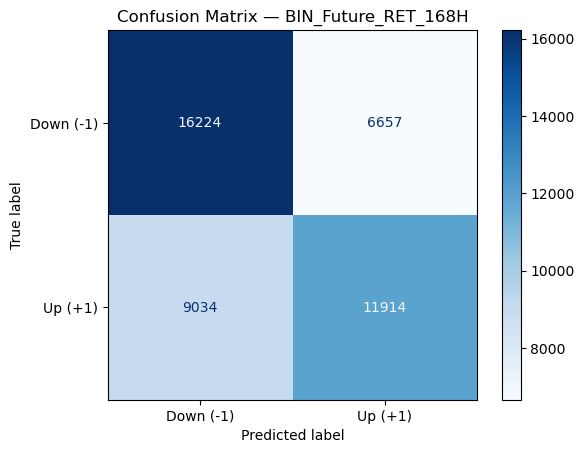

In [5]:

# --- 2. Loop over each target horizon ---
for target in ['BIN_Future_RET_168H']:
    print(f"\n{'='*30}\nTraining model for {target}\n{'='*30}")

    # Sort by coin and date
    df = df.sort_values(["coin", "date"])

    # Use earliest 80% for training, latest 20% for testing
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx]
    test_df  = df.iloc[split_idx:]

    X_train = train_df[features]
    y_train = train_df[target]
    X_test  = test_df[features]
    y_test  = test_df[target]


    # --- Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- Predict ---
    y_pred = rf.predict(X_test)

    # --- Classification metrics ---
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (-1)", "Up (+1)"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {target}")
    plt.show()

In [6]:
def plot_feature_importance(model, feature_names, top_n=25, figsize=(16, 9)):
    """
    Plot the top N most important features from a fitted Random Forest model.

    Parameters
    ----------
    model : fitted sklearn.ensemble.RandomForestClassifier
        The trained Random Forest model.
    feature_names : list[str]
        Names of the input features used during training.
    top_n : int, default 25
        Number of top features to display.
    figsize : tuple, default (10, 6)
        Figure size for the plot.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=figsize)
    plt.barh(range(top_n), importances[indices][::-1], align="center")
    plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
    plt.xlabel("Feature Importance")
    plt.title("Top Feature Importances (Random Forest)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

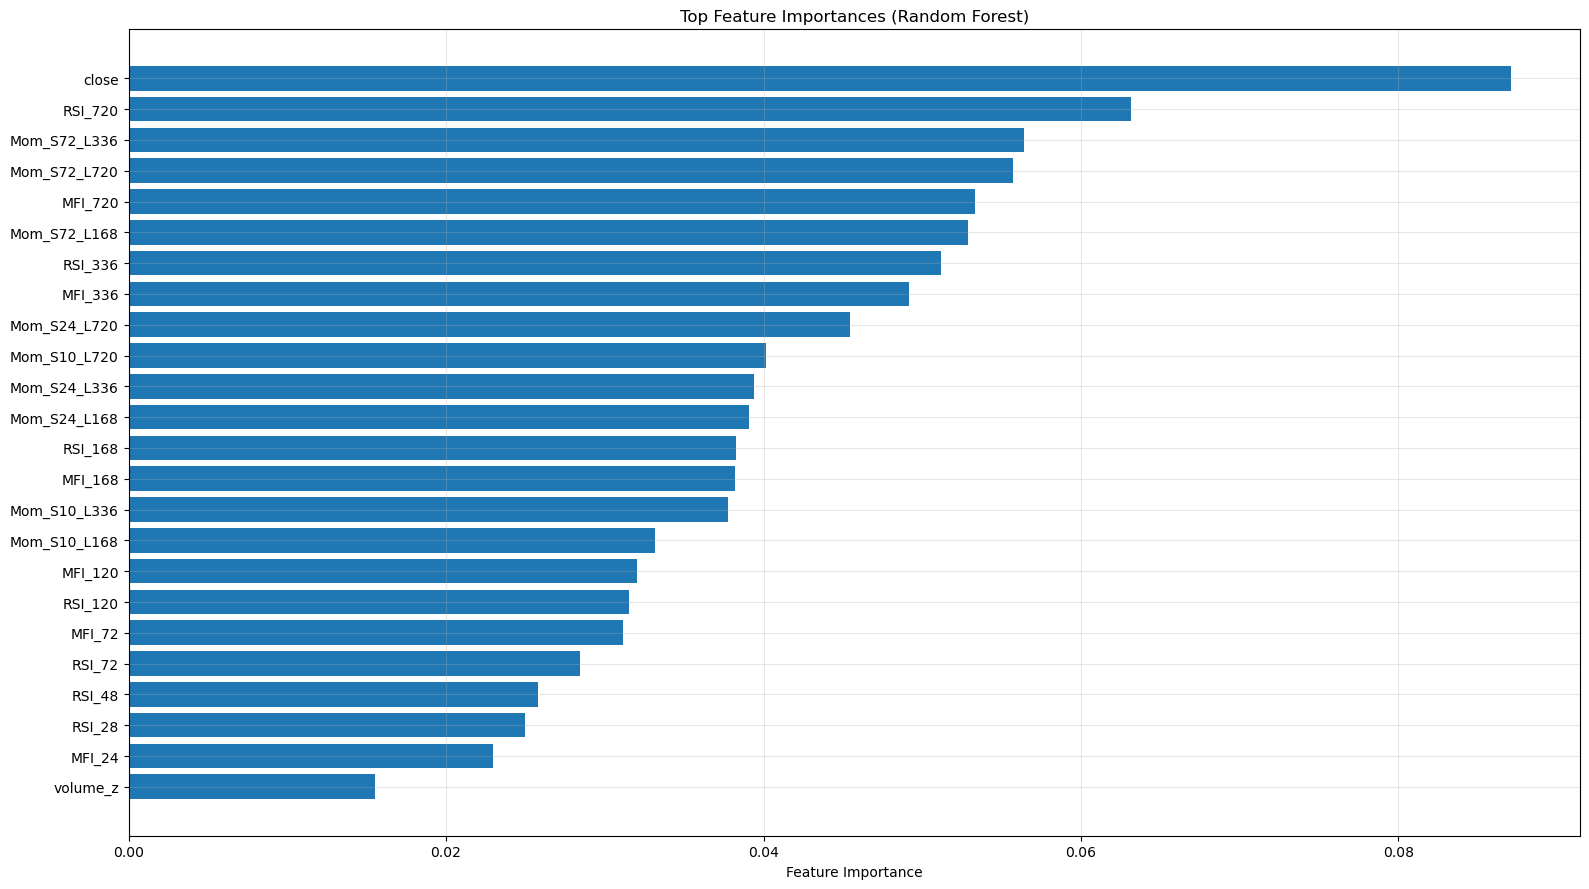

In [7]:
plot_feature_importance(rf, X_train.columns, top_n=24)

In [8]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
y_labels = y_test
X_test.tail()

close  Mom_S10_L168  Mom_S10_L336  \
coin    date                                                       
ZECUSDT 2025-09-10 11:00:00 48.21000       0.06931       0.12171   
        2025-09-10 12:00:00 48.44000       0.06842       0.12126   
        2025-09-10 13:00:00 48.35000       0.06755       0.12074   
        2025-09-10 14:00:00 48.04000       0.06579       0.11925   
        2025-09-10 15:00:00 48.23000       0.06463       0.11838   

                             Mom_S10_L720  Mom_S24_L168  Mom_S24_L336  \
coin    date                                                            
ZECUSDT 2025-09-10 11:00:00       0.17938       0.07398       0.12660   
        2025-09-10 12:00:00       0.17895       0.07160       0.12459   
        2025-09-10 13:00:00       0.17851       0.06926       0.12254   
        2025-09-10 14:00:00       0.17703       0.06702       0.12053   
        2025-09-10 15:00:00       0.17624       0.06522       0.11900   

                             Mom_S24_L720  Mom_S72_L168  Mom_S72_L336  \
coin    date                                                            
ZECUSDT 2025-09-10 11:00:00       0.18453       0.08557       0.13877   
        2025-09-10 12:00:00       0.18246       0.08495       0.13860   
        2025-09-10 13:00:00       0.18040       0.08419       0.13821   
        2025-09-10 14:00:00       0.17839       0.08340       0.13774   
        2025-09-10 15:00:00       0.17689       0.08277       0.13744   

                             Mom_S72_L720   RSI_28   RSI_48   RSI_72  RSI_120  \
coin    date                                                                    
ZECUSDT 2025-09-10 11:00:00       0.19732 32.57443 47.94618 52.42810 59.48038   
        2025-09-10 12:00:00       0.19719 34.07534 49.01961 52.15742 59.59206   
        2025-09-10 13:00:00       0.19688 28.62319 46.47785 50.77369 59.64138   
        2025-09-10 14:00:00       0.19648 28.41727 45.84527 50.09542 60.23962   
        2025-09-10 15:00:00       0.19628 31.55080 48.10219 51.51807 60.43804   

                             RSI_168  RSI_336  RSI_720  volume_z  \
coin    date                                                       
ZECUSDT 2025-09-10 11:00:00 56.66817 53.05455 52.71873  -0.30397   
        2025-09-10 12:00:00 57.14931 53.27176 52.84162  -0.23280   
        2025-09-10 13:00:00 56.80943 53.60381 52.70320  -0.13205   
        2025-09-10 14:00:00 56.31484 53.47050 52.65635  -0.24482   
        2025-09-10 15:00:00 56.50124 53.62466 52.63901  -0.19406   

                             volume_change   MFI_24   MFI_72  MFI_120  \
coin    date                                                            
ZECUSDT 2025-09-10 11:00:00       -0.53035 22.36545 51.77334 58.17458   
        2025-09-10 12:00:00        1.08251 27.08675 50.72441 58.05631   
        2025-09-10 13:00:00        0.73590 33.00373 48.82545 58.19475   
        2025-09-10 14:00:00       -0.47452 34.40570 49.81399 58.22863   
        2025-09-10 15:00:00        0.40650 42.82252 52.36750 58.55121   

                             MFI_168  MFI_336  MFI_720  
coin    date                                            
ZECUSDT 2025-09-10 11:00:00 56.72505 55.36875 55.02909  
        2025-09-10 12:00:00 57.04235 55.63303 55.20574  
        2025-09-10 13:00:00 57.17319 56.00432 55.23638  
        2025-09-10 14:00:00 56.83197 56.02893 55.15789  
        2025-09-10 15:00:00 57.09257 56.27036 55.23787

In [9]:
# ✅ Create df_pred with all needed info
df_pred = X_test.copy()

# Add the true labels
df_pred["true_label"] = y_test.values

# Add model predictions (discrete classes)
df_pred["pred_signal"] = y_pred

# Add model confidence (probability of "up")
df_pred["pred_proba"] = y_proba

# Optional: make a continuous signal strength (-1 to 1)
df_pred["signal_strength"] = (df_pred["pred_proba"] - 0.5) * 2

# Optional: derive binary trading signal based on thresholds
df_pred["trade_signal"] = np.where(df_pred["pred_proba"] > 0.6, 1,
                          np.where(df_pred["pred_proba"] < 0.4, -1, 0))
df_pred = df_pred.reset_index()

df_pred.head()


,coin,date,close,Mom_S10_L168,Mom_S10_L336,Mom_S10_L720,Mom_S24_L168,Mom_S24_L336,Mom_S24_L720,Mom_S72_L168,Mom_S72_L336,Mom_S72_L720,RSI_28,RSI_48,RSI_72,RSI_120,RSI_168,RSI_336,RSI_720,volume_z,volume_change,MFI_24,MFI_72,MFI_120,MFI_168,MFI_336,MFI_720,true_label,pred_signal,pred_proba,signal_strength,trade_signal
0,TAOUSDT,2025-07-28 03:00:00,432.64000,0.00232,0.01030,0.12827,0.00036,0.00832,0.12607,-0.00966,-0.00178,0.11478,55.63275,54.56068,57.41517,48.02378,51.01350,51.22146,53.05897,-0.62391,-0.48390,61.70821,54.56088,41.49324,49.22116,48.88563,52.32122,-1,-1,0.11667,-0.76667,-1
1,TAOUSDT,2025-07-28 04:00:00,432.39000,0.00250,0.01058,0.12818,0.00035,0.00842,0.12576,-0.00912,-0.00113,0.11510,54.40137,53.41827,56.80067,47.57053,50.93910,50.27207,52.99781,-0.58443,0.07124,62.55345,56.73514,41.50420,49.57953,48.24986,52.50384,-1,-1,0.19000,-0.62000,-1
2,TAOUSDT,2025-07-28 05:00:00,437.49000,0.00413,0.01238,0.12981,0.00076,0.00898,0.12602,-0.00833,-0.00018,0.11579,58.28092,54.73137,60.17238,48.37934,51.47319,50.55315,53.09659,0.21145,1.34051,65.18653,60.10916,42.00487,50.17423,47.92450,52.57624,-1,-1,0.30333,-0.39333,-1
3,TAOUSDT,2025-07-28 06:00:00,435.00000,0.00524,0.01355,0.13076,0.00115,0.00942,0.12616,-0.00761,0.00058,0.11630,53.71248,54.01484,58.49336,48.25431,50.86365,50.62689,52.96951,-0.19450,-0.29213,62.82626,59.92568,41.97399,49.63152,48.05310,52.47087,-1,-1,0.26333,-0.47333,-1
4,TAOUSDT,2025-07-28 07:00:00,432.20000,0.00583,0.01414,0.13104,0.00145,0.00973,0.12612,-0.00687,0.00133,0.11675,51.85562,52.00214,57.71970,48.56423,50.30996,50.29817,52.84482,-0.41879,-0.22802,60.87687,57.80727,42.11277,49.18154,47.76710,52.37967,-1,-1,0.26000,-0.48000,-1


In [10]:
import hvplot.pandas  # for interactive plotting
import holoviews as hv
hv.extension('bokeh')

def plot_model_proba_vs_price_z(df, coin, price_col="close", proba_col="pred_proba", date_col="date"):
    """
    Interactive plot of z-scored close price vs. model probability (confidence of upward move).
    """
    data = df[df["coin"] == coin].copy()
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")

    # Z-score normalize the close price per coin
    data["close_z"] = (data[price_col] - data[price_col].mean()) / data[price_col].std()

    # Price (z-scored)
    price_plot = data.hvplot.line(
        x=date_col,
        y="close_z",
        color="blue",
        ylabel="Close (Z-score)",
        label="Z-scored Close Price",
        width=1000,
        height=600,
        tools=["hover", "crosshair"]
    )

    # Model probability (right axis)
    proba_plot = data.hvplot.line(
        x=date_col,
        y=proba_col,
        color="orange",
        ylabel="Model Confidence (Prob[Up])",
        label="Predicted Probability",
        yaxis="right",
        tools=["hover", "crosshair"]
    )

    plot = (price_plot * proba_plot).opts(
        title=f"{coin} — Z-Scored Close vs Model Probability",
        legend_position="top_left"
    )

    return plot


# Example usage:
plot_model_proba_vs_price_z(df_pred, coin="TAOUSDT")


:Overlay
   .Curve.Z_hyphen_minus_scored_Close_Price :Curve   [date]   (close_z)
   .Curve.Predicted_Probability             :Curve   [date]   (pred_proba)

In [11]:
from scipy.stats import pearsonr

coin = "TAOUSDT"

# Filter the coin
sub = df_pred[df_pred["coin"] == coin].copy()

# Compute correlation between model probability and z-scored price
sub["close_z"] = (sub["close"] - sub["close"].mean()) / sub["close"].std()
corr, pval = pearsonr(sub["pred_proba"], sub["close_z"])

print(f"{coin} — Correlation between close_z and pred_proba: {corr:.3f} (p={pval:.3g})")


TAOUSDT — Correlation between close_z and pred_proba: 0.027 (p=0.374)


In [12]:
df_pred = df_pred.merge(
    df.reset_index()[["coin", "date"] + [c for c in df.columns if c.startswith("Future_RET_")]],
    on=["coin", "date"],
    how="left"
)
df_pred.head()

,coin,date,close,Mom_S10_L168,Mom_S10_L336,Mom_S10_L720,Mom_S24_L168,Mom_S24_L336,Mom_S24_L720,Mom_S72_L168,Mom_S72_L336,Mom_S72_L720,RSI_28,RSI_48,RSI_72,RSI_120,RSI_168,RSI_336,RSI_720,volume_z,volume_change,MFI_24,MFI_72,MFI_120,MFI_168,MFI_336,MFI_720,true_label,pred_signal,pred_proba,signal_strength,trade_signal,Future_RET_24H,Future_RET_72H,Future_RET_120H,Future_RET_168H,Future_RET_336H,Future_RET_720H
0,TAOUSDT,2025-07-28 03:00:00,432.64000,0.00232,0.01030,0.12827,0.00036,0.00832,0.12607,-0.00966,-0.00178,0.11478,55.63275,54.56068,57.41517,48.02378,51.01350,51.22146,53.05897,-0.62391,-0.48390,61.70821,54.56088,41.49324,49.22116,48.88563,52.32122,-1,-1,0.11667,-0.76667,-1,-0.07073,-0.12918,-0.19924,-0.18376,-0.08515,-0.22173
1,TAOUSDT,2025-07-28 04:00:00,432.39000,0.00250,0.01058,0.12818,0.00035,0.00842,0.12576,-0.00912,-0.00113,0.11510,54.40137,53.41827,56.80067,47.57053,50.93910,50.27207,52.99781,-0.58443,0.07124,62.55345,56.73514,41.50420,49.57953,48.24986,52.50384,-1,-1,0.19000,-0.62000,-1,-0.07678,-0.12364,-0.19353,-0.18465,-0.08546,-0.21393
2,TAOUSDT,2025-07-28 05:00:00,437.49000,0.00413,0.01238,0.12981,0.00076,0.00898,0.12602,-0.00833,-0.00018,0.11579,58.28092,54.73137,60.17238,48.37934,51.47319,50.55315,53.09659,0.21145,1.34051,65.18653,60.10916,42.00487,50.17423,47.92450,52.57624,-1,-1,0.30333,-0.39333,-1,-0.07589,-0.13673,-0.20467,-0.19116,-0.09911,-0.22842
3,TAOUSDT,2025-07-28 06:00:00,435.00000,0.00524,0.01355,0.13076,0.00115,0.00942,0.12616,-0.00761,0.00058,0.11630,53.71248,54.01484,58.49336,48.25431,50.86365,50.62689,52.96951,-0.19450,-0.29213,62.82626,59.92568,41.97399,49.63152,48.05310,52.47087,-1,-1,0.26333,-0.47333,-1,-0.06621,-0.12563,-0.21547,-0.18566,-0.09621,-0.22816
4,TAOUSDT,2025-07-28 07:00:00,432.20000,0.00583,0.01414,0.13104,0.00145,0.00973,0.12612,-0.00687,0.00133,0.11675,51.85562,52.00214,57.71970,48.56423,50.30996,50.29817,52.84482,-0.41879,-0.22802,60.87687,57.80727,42.11277,49.18154,47.76710,52.37967,-1,-1,0.26000,-0.48000,-1,-0.05335,-0.12499,-0.19988,-0.17480,-0.10953,-0.22388


In [13]:
from scipy.stats import pearsonr

coin = "TAOUSDT"
sub = df_pred[df_pred["coin"] == coin].copy()

# Drop NaNs to ensure fair correlation
sub = sub.dropna(subset=["pred_proba"])

future_cols = [c for c in sub.columns if c.startswith("Future_RET_")]
results = []

for col in future_cols:
    corr, pval = pearsonr(sub["pred_proba"], sub[col])
    results.append((col, corr, pval))

corr_df = pd.DataFrame(results, columns=["Future_Horizon", "Correlation", "p_value"])
print(corr_df)


    Future_Horizon  Correlation  p_value
0   Future_RET_24H      0.11335  0.00020
1   Future_RET_72H      0.25844  0.00000
2  Future_RET_120H      0.34704  0.00000
3  Future_RET_168H      0.38344  0.00000
4  Future_RET_336H      0.11910  0.00009
5  Future_RET_720H     -0.00712  0.81609
